# **0. 개요**

이번 과제는 YOLO에서 제공하는 ultralytics를 이용해서 YOLO 모델을 불러와서 WIDER FACE 라는 사람들 얼굴 dataset을 이용해서 학습시켜 보는 것이다.

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.9/921.9 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
import os
import cv2
import shutil
import random
import yaml
import glob
import urllib.request
import zipfile
import pandas as pd
from tqdm import tqdm
import zipfile
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# **1. DATASET 전처리**

## **DATASET 소개**  
WIDER FACE는 얼굴 탐지(Face Detection) 연구를 위해 개발된 대규모 공개 데이터셋으로, 다양한 조명, 포즈, 가려짐(occlusion) 등과 같은 어려운 조건에서도 얼굴을 탐지하는 모델을 학습하고 평가하는 데 사용된다.

WIDER FACE는 **Train, Validation, Test** 세 개의 서브셋으로 나뉘며,  
총 **32,203장의 이미지**와 **393,703개의 얼굴 bounding box 주석**이 포함되어 있다.

---

## **DATASET 구성**  
총 5가지 파일이 존재하며, 주요 내용은 다음과 같다:

- **`WIDER_train`** : 학습(Train) 데이터 이미지  
- **`WIDER_val`** : 검증(Validation) 데이터 이미지  
- **`WIDER_test`** : 테스트(Test) 데이터 이미지  
- **`wider_face_split`** : Ground Truth (GT) Bounding Box 좌표 정보  
- **기타 .mat 파일** : 신경 쓰지 않아도 됨  

이 때 GT Bounding Box 정보는 x1, y1, width, hegiht 인데, x1, y1 은 좌 상단의 좌표를 뜻한다.

##**YOLO**
YOLO는 그 데이터 형식으로 x_center, y_center, width, height 를 받게 되는데, 이 모든 데이터가 input image에 대한 size 로 정규화 해서 0~1 사이의 값을 가져야 한다.

##**전처리 방법**

1. unzip_file 을 통해 google drive에 올린 데이터를 unzip 해준다.

2. convert_widerface_to_yolo 를 통해서 WIDER 데이터의 gt box 값을 YOLO 형식으로 바꿔줘야 하는데, 이를 위해 각 파일을 열고, 그 파일에서 필요한 정보값만 취하는데, image에 대한 width height 값을 bounding box로만 추정할 수 없기 때문에, 우선 label 에 있는 데이터들을 정리해 필요한 것들만 뽑고, 따로 저장해준다. 이때, 전체 데이터를 쓸 수 있겠지만, 너무 오랜 시간이 걸려, colab 사정상 각 category 별 10개만 뽑아 사용하기로 했다.

3. make_dataset 을 통해 YOLO에서 사용 가능한, data로 가공한다. 여기서는 이제 image 와 label 쌍을 만들고 이를 dataset이라는 폴더에 잘 저장한다. 이 때, 각 쌍을 찾고, 찾은 image에 대해 opencv 를 이용해 width 와 height 를 추출하여, 이를 통해 normalize 해준다.


In [3]:
def unzip_file(file_path, extract_path):
    if not os.path.exists(extract_path):
        os.makedirs(extract_path)

    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    print(f'Unzipped {file_path} to {extract_path}')

In [4]:
extract_path = "/content/"
train_path = "/content/drive/MyDrive/WIDER_train.zip"
unzip_file(train_path, extract_path)

Unzipped /content/drive/MyDrive/WIDER_train.zip to /content/


In [5]:
split_path = "/content/drive/MyDrive/wider_face_split.zip"
unzip_file(split_path, extract_path)

Unzipped /content/drive/MyDrive/wider_face_split.zip to /content/


In [6]:
valid_path = "/content/drive/MyDrive/WIDER_val.zip"
unzip_file(valid_path, extract_path)

Unzipped /content/drive/MyDrive/WIDER_val.zip to /content/


In [7]:
test_path = "/content/drive/MyDrive/WIDER_test.zip"
unzip_file(test_path, extract_path)

Unzipped /content/drive/MyDrive/WIDER_test.zip to /content/


In [8]:
import os

def convert_widerface_to_yolo(widerface_txt, output_dir, max_per_dir=10):

    os.makedirs(output_dir, exist_ok=True)

    with open(widerface_txt, "r") as f:
        lines = f.readlines()

    i = 0
    dir_counts = {}

    while i < len(lines):
        line = lines[i].strip()

        if "/" in line and ".jpg" in line:
            img_path = line.split("/")
            dir_name = img_path[0]
            img_filename = img_path[-1]
            img_basename = os.path.splitext(img_filename)[0]

            if dir_counts.get(dir_name, 0) >= max_per_dir:
                i += 1
                while i < len(lines) and not ("/" in lines[i] and ".jpg" in lines[i]):
                    i += 1
                continue

            i += 1
            face_count = int(lines[i].strip())
            i += 1

            yolo_lines = []
            for _ in range(face_count):
                bbox = list(map(int, lines[i].strip().split()[:4]))
                i += 1

                x, y, w, h = bbox
                x_center = (x + w / 2)
                y_center = (y + h / 2)
                w = w
                h = h

                yolo_lines.append(f"0 {x_center} {y_center} {w} {h}")

            yolo_txt_path = os.path.join(output_dir, f"{img_basename}.txt")
            with open(yolo_txt_path, "w") as yolo_file:
                yolo_file.write("\n".join(yolo_lines))

            dir_counts[dir_name] = dir_counts.get(dir_name, 0) + 1

    print(f"각 디렉터리에서 {max_per_dir}개 변환 완료!")

convert_widerface_to_yolo("/content/wider_face_split/wider_face_train_bbx_gt.txt", "yolo_train_labels")
convert_widerface_to_yolo("/content/wider_face_split/wider_face_val_bbx_gt.txt", "yolo_val_labels", max_per_dir=2)

각 디렉터리에서 10개 변환 완료!
각 디렉터리에서 2개 변환 완료!


<class_id> <x_center> <y_center> <width> <height>

In [9]:
import os
import shutil
import cv2

def make_dataset(image_dir, label_dir, output_image_dir, output_label_dir):
    os.makedirs(output_image_dir, exist_ok=True)
    os.makedirs(output_label_dir, exist_ok=True)

    for root, _, files in os.walk(image_dir):
        for file in files:
            if file.endswith(".jpg"):
                img_path = os.path.join(root, file)
                label_path = os.path.join(label_dir, file.replace(".jpg", ".txt"))

                if os.path.exists(label_path):
                    # 이미지 크기 가져오기
                    img = cv2.imread(img_path)
                    if img is None:
                        print(f"이미지 로드 실패: {img_path}")
                        continue
                    img_h, img_w, _ = img.shape

                    # YOLO 라벨 정규화
                    normalized_labels = []
                    with open(label_path, "r") as f:
                        lines = f.readlines()
                        for line in lines:
                            parts = line.strip().split()
                            if len(parts) < 5:
                                continue  # 잘못된 형식 무시
                            class_id, x1, y1, w, h = map(float, parts[:5])

                            # x1, y1이 좌상단 기준이라면, 중심 좌표 계산
                            x_center = x1 / img_w
                            y_center = y1 / img_h
                            w_norm = w / img_w
                            h_norm = h / img_h

                            normalized_labels.append(f"{int(class_id)} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}")

                    # 정규화된 라벨 저장
                    output_label_path = os.path.join(output_label_dir, file.replace(".jpg", ".txt"))
                    with open(output_label_path, "w") as f:
                        f.write("\n".join(normalized_labels))

                    # 이미지 복사
                    shutil.copy(img_path, os.path.join(output_image_dir, file))

    print(f"이미지 & 라벨 정리 및 정규화 완료: {output_image_dir}, {output_label_dir}")

# 데이터셋 정리 및 정규화 실행
image_dir = "/content/WIDER_train/images"
label_dir = "/content/yolo_train_labels"
output_image_dir = "/content/dataset/images/train"
output_label_dir = "/content/dataset/labels/train"

make_dataset(image_dir, label_dir, output_image_dir, output_label_dir)

image_dir = "/content/WIDER_val/images"
label_dir = "/content/yolo_val_labels"
output_image_dir = "/content/dataset/images/val"
output_label_dir = "/content/dataset/labels/val"

make_dataset(image_dir, label_dir, output_image_dir, output_label_dir)


이미지 & 라벨 정리 및 정규화 완료: /content/dataset/images/train, /content/dataset/labels/train
이미지 & 라벨 정리 및 정규화 완료: /content/dataset/images/val, /content/dataset/labels/val


# **2. 모델 선정 및 학습**

## **YOLO 모델 선정**  
얼굴 탐지 모델로 **YOLOv8n**을 사용하였다.  
YOLOv8n은 경량화된 모델로, 비교적 적은 연산량으로도 높은 성능을 보인다.  

별다른 추가 설정 없이 **yaml 파일**을 생성한 후, 이를 모델에 넘겨주어 YOLO 학습이 가능했다.  

---

## **YOLO 학습을 위한 yaml 파일 구성**  
다음과 같은 형식으로 yaml 파일을 작성하면 된다.

```yaml
train: /content/dataset/images/train
val: /content/dataset/images/val

nc: 1  
names: ["face"]


epoch 수는 처음 총 2번 실험했는데, 50, 100 총 두 개에 대한 실험을 진행했고, 그 결과는 아래서 분석하겠다.

In [14]:
model = YOLO("yolov8n.pt")

model.train(data="/content/dataset/yolo.yaml",
            epochs=100,
            batch=16,
            imgsz=640,
            device="cuda")


Ultralytics 8.3.80 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/dataset/yolo.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_box

train: Scanning /content/dataset/labels/train.cache... 610 images, 0 backgrounds, 0 corrupt: 100%|██████████| 610/610 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/dataset/labels/val.cache... 122 images, 0 backgrounds, 0 corrupt: 100%|██████████| 122/122 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      8.93G      2.348      2.756      1.512         20        640: 100%|██████████| 39/39 [00:17<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]

                   all        122       1143      0.011      0.352     0.0177    0.00863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100       6.1G      2.017      1.794      1.267         25        640: 100%|██████████| 39/39 [00:14<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]

                   all        122       1143      0.636      0.145       0.19     0.0976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      10.5G      2.007      1.718      1.227         25        640: 100%|██████████| 39/39 [00:13<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.52it/s]

                   all        122       1143      0.382      0.264      0.191     0.0956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.03G      2.015      1.637      1.243         11        640: 100%|██████████| 39/39 [00:13<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.57it/s]

                   all        122       1143      0.537      0.288      0.294      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      7.12G      1.909      1.554      1.204         11        640: 100%|██████████| 39/39 [00:13<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.96it/s]

                   all        122       1143      0.549      0.255      0.278      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      11.7G      1.924       1.43      1.156         32        640: 100%|██████████| 39/39 [00:14<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.03it/s]

                   all        122       1143      0.566      0.346      0.337      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      5.57G      1.855      1.408      1.162         27        640: 100%|██████████| 39/39 [00:13<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

                   all        122       1143      0.699      0.352      0.394      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100       7.7G      1.831       1.33      1.158          9        640: 100%|██████████| 39/39 [00:13<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]

                   all        122       1143       0.68      0.301      0.337      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      11.7G       1.96      1.405      1.175         29        640: 100%|██████████| 39/39 [00:13<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]

                   all        122       1143      0.639      0.304      0.345      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      10.3G      1.805       1.27      1.141         12        640: 100%|██████████| 39/39 [00:13<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.52it/s]

                   all        122       1143      0.572      0.334      0.336      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      12.8G      1.822      1.257      1.151         17        640: 100%|██████████| 39/39 [00:14<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.62it/s]

                   all        122       1143      0.694      0.367      0.404      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      10.8G      1.866      1.307      1.141          3        640: 100%|██████████| 39/39 [00:14<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]

                   all        122       1143       0.71      0.358      0.399      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.38G      1.758       1.24      1.157         91        640: 100%|██████████| 39/39 [00:13<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]

                   all        122       1143      0.691      0.372      0.421      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      7.73G      1.766      1.207      1.138          3        640: 100%|██████████| 39/39 [00:13<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        122       1143      0.643       0.37      0.404      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      10.6G      1.738      1.189      1.102         12        640: 100%|██████████| 39/39 [00:14<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]

                   all        122       1143      0.683      0.376      0.429       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         4G      1.689      1.166      1.115          7        640: 100%|██████████| 39/39 [00:12<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]

                   all        122       1143      0.713      0.385      0.439      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      9.22G      1.725       1.16      1.117         12        640: 100%|██████████| 39/39 [00:12<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]

                   all        122       1143      0.699      0.397      0.439      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      10.7G      1.746      1.145      1.116         13        640: 100%|██████████| 39/39 [00:14<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

                   all        122       1143      0.671      0.355      0.395      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      8.64G      1.816        1.2      1.134          5        640: 100%|██████████| 39/39 [00:14<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


                   all        122       1143      0.675      0.374       0.41      0.214

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.58G      1.652      1.104      1.103          5        640: 100%|██████████| 39/39 [00:13<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


                   all        122       1143      0.726      0.371      0.418      0.214

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      11.1G      1.717      1.118      1.114         11        640: 100%|██████████| 39/39 [00:14<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]

                   all        122       1143      0.717      0.384      0.425      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.31G      1.718      1.139      1.098       1770        640: 100%|██████████| 39/39 [00:13<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]

                   all        122       1143      0.762      0.392       0.46      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      11.6G      1.669      1.083      1.092         42        640: 100%|██████████| 39/39 [00:14<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.22it/s]

                   all        122       1143      0.747      0.379      0.441      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      12.2G      1.752      1.116       1.09         79        640: 100%|██████████| 39/39 [00:13<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all        122       1143      0.764      0.398      0.449      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      12.2G      1.658      1.066      1.089         30        640: 100%|██████████| 39/39 [00:13<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

                   all        122       1143      0.725      0.383      0.438      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      6.25G       1.62      1.032       1.08         10        640: 100%|██████████| 39/39 [00:13<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.68it/s]

                   all        122       1143      0.768        0.4      0.461      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      8.85G      1.642      1.073      1.084          3        640: 100%|██████████| 39/39 [00:13<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

                   all        122       1143      0.714      0.383      0.429      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      6.32G      1.674      1.087      1.073         13        640: 100%|██████████| 39/39 [00:13<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all        122       1143      0.778      0.383      0.441      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      6.38G      1.643      1.063      1.075         38        640: 100%|██████████| 39/39 [00:15<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.00it/s]

                   all        122       1143      0.728      0.391      0.438       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      8.77G      1.606      1.035      1.079          3        640: 100%|██████████| 39/39 [00:15<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]

                   all        122       1143      0.676      0.389      0.419      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.43G      1.627       1.07      1.086         85        640: 100%|██████████| 39/39 [00:15<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        122       1143      0.807      0.399      0.454      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      10.7G      1.675      1.057      1.075         11        640: 100%|██████████| 39/39 [00:13<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

                   all        122       1143      0.759      0.403      0.461      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100       5.2G       1.65      1.011      1.079          8        640: 100%|██████████| 39/39 [00:15<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]

                   all        122       1143      0.757      0.396      0.453      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      10.1G       1.62      1.033      1.062        121        640: 100%|██████████| 39/39 [00:15<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]

                   all        122       1143      0.748      0.377      0.434      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      10.3G      1.639      1.018      1.063         19        640: 100%|██████████| 39/39 [00:13<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

                   all        122       1143      0.729      0.392      0.454      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      7.78G      1.601      0.966      1.071         11        640: 100%|██████████| 39/39 [00:13<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.60it/s]

                   all        122       1143      0.747      0.413      0.454      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      10.7G      1.575      1.002      1.077         12        640: 100%|██████████| 39/39 [00:14<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]

                   all        122       1143      0.736      0.427      0.478      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      11.4G       1.59      0.998      1.065          5        640: 100%|██████████| 39/39 [00:14<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

                   all        122       1143      0.755       0.41      0.469      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      13.3G      1.554     0.9493      1.047          8        640: 100%|██████████| 39/39 [00:14<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all        122       1143      0.747      0.418      0.474       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      12.3G      1.602     0.9774      1.074         11        640: 100%|██████████| 39/39 [00:14<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.54it/s]

                   all        122       1143      0.716      0.402      0.445      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      9.43G      1.604     0.9645      1.061          8        640: 100%|██████████| 39/39 [00:14<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all        122       1143      0.751      0.387      0.437      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      5.01G      1.595     0.9643      1.049          9        640: 100%|██████████| 39/39 [00:17<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all        122       1143      0.777      0.371      0.436      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      12.5G      1.615     0.9705      1.049          9        640: 100%|██████████| 39/39 [00:15<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all        122       1143       0.76      0.408      0.464      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      5.42G       1.57      0.949      1.041         29        640: 100%|██████████| 39/39 [00:15<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.01it/s]


                   all        122       1143      0.745      0.398      0.449      0.242

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      6.45G       1.53     0.9316      1.055         37        640: 100%|██████████| 39/39 [00:15<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        122       1143       0.76      0.405      0.462      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      7.78G      1.631     0.9722      1.058         24        640: 100%|██████████| 39/39 [00:14<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

                   all        122       1143        0.8      0.401      0.478       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      11.7G      1.554       0.94      1.043          5        640: 100%|██████████| 39/39 [00:14<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        122       1143       0.75      0.422      0.476      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      8.74G      1.568     0.9237      1.035        159        640: 100%|██████████| 39/39 [00:14<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]

                   all        122       1143      0.687      0.414      0.456      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      13.6G       1.57     0.9361      1.046         51        640: 100%|██████████| 39/39 [00:14<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        122       1143      0.799      0.397      0.457      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      9.12G      1.511     0.9169      1.053          7        640: 100%|██████████| 39/39 [00:13<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        122       1143      0.775      0.405      0.461      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      7.48G      1.497     0.8857      1.027         28        640: 100%|██████████| 39/39 [00:13<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.54it/s]

                   all        122       1143      0.822      0.418      0.488       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      9.05G      1.489     0.8827      1.037          2        640: 100%|██████████| 39/39 [00:15<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.59it/s]

                   all        122       1143      0.813      0.409      0.481      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      8.97G      1.488     0.8752      1.022         23        640: 100%|██████████| 39/39 [00:13<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]

                   all        122       1143      0.804      0.404      0.473      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100       9.2G      1.513     0.8857       1.02         78        640: 100%|██████████| 39/39 [00:13<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]


                   all        122       1143      0.752      0.423      0.485      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      3.31G      1.506     0.9117      1.036         11        640: 100%|██████████| 39/39 [00:13<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]

                   all        122       1143      0.798      0.376      0.444       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      4.66G      1.481      0.877      1.022         17        640: 100%|██████████| 39/39 [00:14<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]

                   all        122       1143      0.791      0.414      0.479       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100       9.3G      1.433     0.8374      1.027         33        640: 100%|██████████| 39/39 [00:15<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        122       1143      0.771      0.425      0.489       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.16G      1.484     0.8902      1.022         24        640: 100%|██████████| 39/39 [00:14<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  2.00it/s]

                   all        122       1143      0.759      0.422      0.477      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      7.39G      1.474     0.8489      1.021        130        640: 100%|██████████| 39/39 [00:15<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]

                   all        122       1143       0.79      0.408      0.481      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      8.86G      1.463     0.8587       1.02          3        640: 100%|██████████| 39/39 [00:16<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.49it/s]

                   all        122       1143      0.782       0.42      0.479      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.98G      1.438     0.8281      1.013         20        640: 100%|██████████| 39/39 [00:14<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        122       1143      0.809       0.43      0.501      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      12.9G      1.497     0.8626      1.021         17        640: 100%|██████████| 39/39 [00:15<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        122       1143      0.749      0.435      0.485       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      7.87G      1.499     0.8842      1.026          4        640: 100%|██████████| 39/39 [00:14<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]

                   all        122       1143       0.79      0.422      0.501      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      12.6G      1.458     0.8237      1.013         17        640: 100%|██████████| 39/39 [00:15<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]

                   all        122       1143      0.733      0.422      0.469      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      6.02G      1.424     0.8201       1.01         10        640: 100%|██████████| 39/39 [00:15<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

                   all        122       1143      0.773      0.426      0.485      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      8.79G      1.466     0.8452      1.031         38        640: 100%|██████████| 39/39 [00:16<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all        122       1143      0.777      0.439      0.501      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.92G      1.442     0.8242      1.014          7        640: 100%|██████████| 39/39 [00:14<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

                   all        122       1143       0.76      0.437      0.504      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.28G      1.372     0.8039      1.005          9        640: 100%|██████████| 39/39 [00:15<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]

                   all        122       1143      0.735       0.43      0.487      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      11.9G       1.47     0.8251      1.001         10        640: 100%|██████████| 39/39 [00:14<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]

                   all        122       1143      0.775      0.419      0.485      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      12.6G      1.429     0.8141     0.9961         11        640: 100%|██████████| 39/39 [00:14<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]

                   all        122       1143      0.797      0.425      0.495      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      8.02G      1.398     0.8096      1.016          5        640: 100%|██████████| 39/39 [00:15<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        122       1143      0.782      0.415      0.487      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.46G      1.374     0.7614     0.9841         50        640: 100%|██████████| 39/39 [00:14<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]


                   all        122       1143      0.763      0.428      0.488      0.258

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      8.32G      1.478     0.8373      1.002         22        640: 100%|██████████| 39/39 [00:15<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

                   all        122       1143      0.787       0.43      0.494      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      6.92G       1.37     0.7691     0.9889          7        640: 100%|██████████| 39/39 [00:13<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]

                   all        122       1143       0.76      0.431      0.499      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      10.2G       1.44     0.7907     0.9919          5        640: 100%|██████████| 39/39 [00:15<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all        122       1143      0.785      0.437      0.498      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      6.37G      1.406     0.7753     0.9792         16        640: 100%|██████████| 39/39 [00:14<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        122       1143      0.749      0.426      0.484      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      7.26G       1.34     0.7729     0.9744         47        640: 100%|██████████| 39/39 [00:15<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.04it/s]

                   all        122       1143      0.747      0.436      0.491      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.18G      1.356     0.7553      0.986         10        640: 100%|██████████| 39/39 [00:14<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all        122       1143      0.794      0.437      0.497      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      3.42G      1.385     0.8114     0.9886         24        640: 100%|██████████| 39/39 [00:14<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        122       1143      0.773      0.426      0.488      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      9.47G      1.435     0.7801     0.9798         44        640: 100%|██████████| 39/39 [00:14<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]

                   all        122       1143      0.805      0.416      0.497      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      9.98G      1.382     0.7542     0.9778         53        640: 100%|██████████| 39/39 [00:14<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        122       1143      0.804      0.428      0.494      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      7.44G      1.433     0.7932     0.9889         14        640: 100%|██████████| 39/39 [00:14<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

                   all        122       1143      0.729      0.431      0.473      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      9.17G      1.431     0.7973      0.972         16        640: 100%|██████████| 39/39 [00:15<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all        122       1143      0.774      0.445      0.494      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      7.31G      1.373     0.7573     0.9788         56        640: 100%|██████████| 39/39 [00:14<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.22it/s]

                   all        122       1143      0.781      0.435      0.492      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      10.8G       1.35     0.7459     0.9697         24        640: 100%|██████████| 39/39 [00:14<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]

                   all        122       1143      0.756      0.442      0.491      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100       6.5G      1.347     0.7351     0.9693         20        640: 100%|██████████| 39/39 [00:14<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.66it/s]

                   all        122       1143      0.801      0.427      0.494      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      4.45G      1.294     0.7266     0.9801         10        640: 100%|██████████| 39/39 [00:15<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]

                   all        122       1143      0.793       0.42      0.491      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      14.5G      1.366     0.7491     0.9715         29        640: 100%|██████████| 39/39 [00:15<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

                   all        122       1143      0.731      0.441      0.486      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      5.77G       1.38     0.7478     0.9664         16        640: 100%|██████████| 39/39 [00:13<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]

                   all        122       1143      0.768      0.437      0.497      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      7.48G       1.27     0.7114     0.9576          5        640: 100%|██████████| 39/39 [00:14<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]

                   all        122       1143      0.765      0.434      0.498      0.264


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      10.2G      1.346     0.7422     0.9596         51        640: 100%|██████████| 39/39 [00:18<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]

                   all        122       1143      0.771      0.438      0.495      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      7.55G      1.282     0.7066     0.9675          2        640: 100%|██████████| 39/39 [00:14<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.20it/s]

                   all        122       1143      0.794      0.431      0.494      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      8.05G      1.302     0.7047     0.9529         12        640: 100%|██████████| 39/39 [00:17<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all        122       1143      0.757      0.433      0.488      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100       7.4G      1.285     0.6856     0.9567          6        640: 100%|██████████| 39/39 [00:12<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.66it/s]

                   all        122       1143      0.771      0.423      0.488      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      9.97G      1.274     0.6781     0.9555          3        640: 100%|██████████| 39/39 [00:12<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        122       1143      0.759      0.428      0.489      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      7.28G       1.26     0.6742     0.9476          2        640: 100%|██████████| 39/39 [00:13<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

                   all        122       1143      0.756      0.437      0.495      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      6.71G      1.259     0.6817     0.9474         58        640: 100%|██████████| 39/39 [00:13<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

                   all        122       1143      0.748      0.436      0.491      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      9.14G      1.283     0.6825     0.9564         17        640: 100%|██████████| 39/39 [00:15<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        122       1143      0.778      0.422      0.489      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      9.55G      1.244     0.6562     0.9684          2        640: 100%|██████████| 39/39 [00:14<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        122       1143      0.744      0.435      0.488      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      7.64G      1.263     0.6823     0.9539          6        640: 100%|██████████| 39/39 [00:14<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]

                   all        122       1143      0.751      0.438      0.493      0.266



100 epochs completed in 0.487 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.2MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.80 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


                   all        122       1143      0.784      0.437      0.497      0.268
Speed: 0.2ms preprocess, 3.2ms inference, 0.0ms loss, 5.8ms postprocess per image
Results saved to runs/detect/train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7efc856aa850>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [15]:
model.val()

Ultralytics 8.3.80 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/dataset/labels/val.cache... 122 images, 0 backgrounds, 0 corrupt: 100%|██████████| 122/122 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


                   all        122       1143      0.792      0.433      0.498      0.269
Speed: 8.1ms preprocess, 7.5ms inference, 0.0ms loss, 5.9ms postprocess per image
Results saved to runs/detect/train32


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7efc8389f9d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [16]:
test_images = [
    "/content/WIDER_train/images/0--Parade/0_Parade_Parade_0_1014.jpg",
    "/content/WIDER_train/images/18--Concerts/18_Concerts_Concerts_18_100.jpg",
    "/content/WIDER_test/images/20--Family_Group/20_Family_Group_Family_Group_20_1.jpg"
]

for img in test_images:
    results = model.predict(source=img, save=True, imgsz=640, conf=0.2)

    # 결과 리스트를 출력
    for result in results:
      print(result.boxes)



image 1/1 /content/WIDER_train/images/0--Parade/0_Parade_Parade_0_1014.jpg: 480x640 1 face, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/detect/train33
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.], device='cuda:0')
conf: tensor([0.4021], device='cuda:0')
data: tensor([[245.8759, 377.9510, 259.5137, 393.2357,   0.4021,   0.0000]], device='cuda:0')
id: None
is_track: False
orig_shape: (732, 1024)
shape: torch.Size([1, 6])
xywh: tensor([[252.6948, 385.5933,  13.6378,  15.2847]], device='cuda:0')
xywhn: tensor([[0.2468, 0.5268, 0.0133, 0.0209]], device='cuda:0')
xyxy: tensor([[245.8759, 377.9510, 259.5137, 393.2357]], device='cuda:0')
xyxyn: tensor([[0.2401, 0.5163, 0.2534, 0.5372]], device='cuda:0')

image 1/1 /content/WIDER_train/images/18--Concerts/18_Concerts_Concerts_18_100.jpg: 640x544 1 face, 8.5ms
Speed: 3.2ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shap

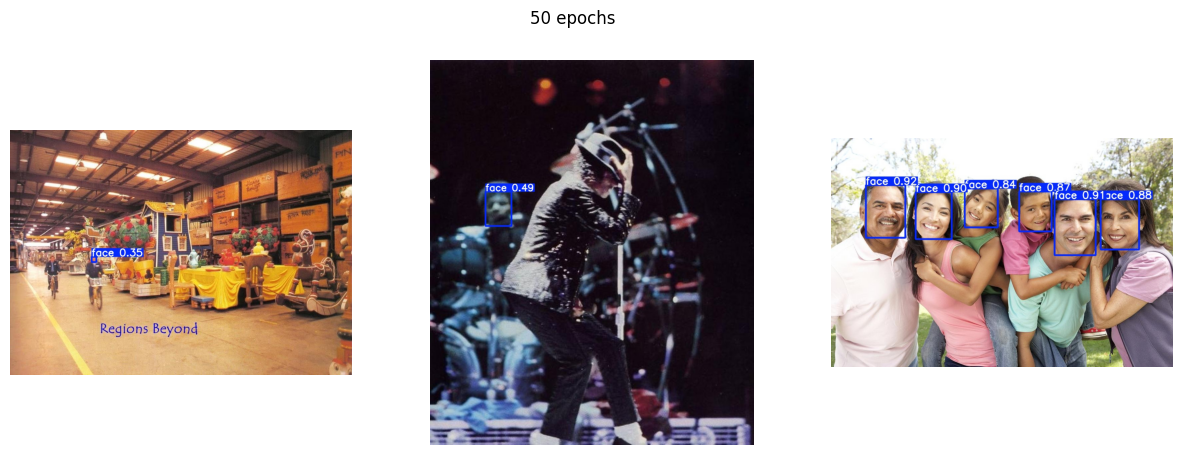

In [19]:
import matplotlib.pyplot as plt
import cv2

# 이미지 리스트
img_list = [
    "/content/runs/detect/train23/0_Parade_Parade_0_1014.jpg",
    "/content/runs/detect/train24/18_Concerts_Concerts_18_100.jpg",
    "/content/runs/detect/train25/20_Family_Group_Family_Group_20_1.jpg"
]

# 그림 사이즈 설정
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, img_path in zip(axes, img_list):
    img = cv2.imread(img_path)  # 이미지 읽기
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR이므로 RGB로 변환
    ax.imshow(img)
    ax.axis("off")  # 축 숨기기

plt.suptitle("50 epochs")
plt.show()


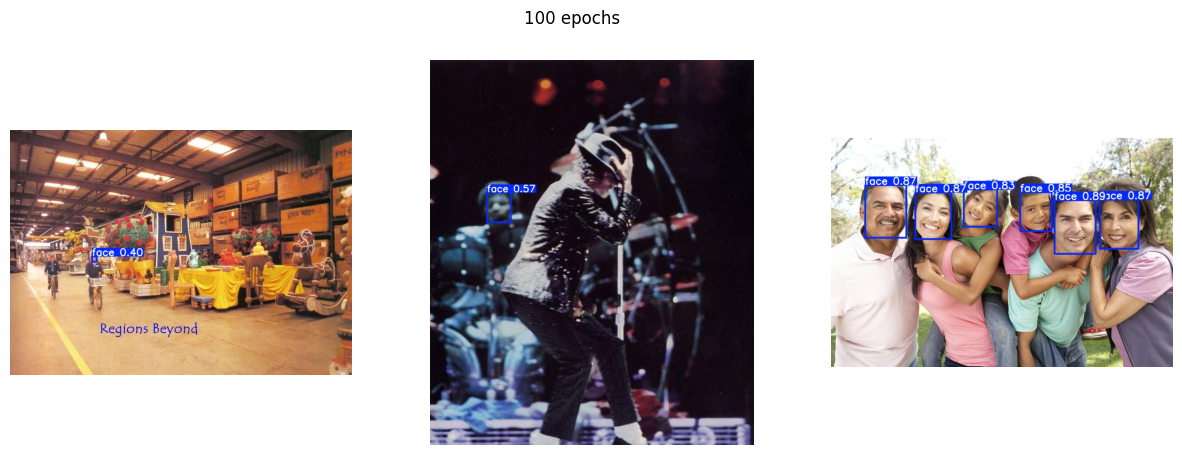

In [21]:
img_list = [
    "/content/runs/detect/train33/0_Parade_Parade_0_1014.jpg",
    "/content/runs/detect/train34/18_Concerts_Concerts_18_100.jpg",
    "/content/runs/detect/train35/20_Family_Group_Family_Group_20_1.jpg"
]

# 그림 사이즈 설정
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, img_path in zip(axes, img_list):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.axis("off")

plt.suptitle("100 epochs")
plt.show()


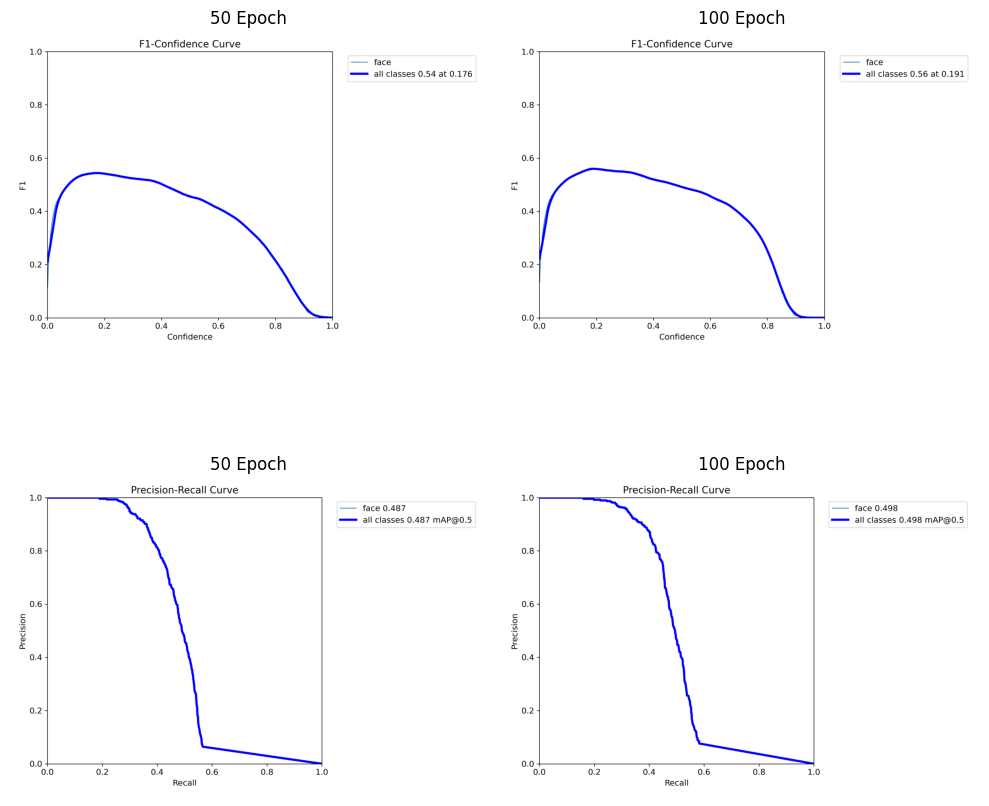

In [24]:
# 이미지 파일 경로 리스트
img_list = [
    "/content/runs/detect/train22/F1_curve.png",
    "/content/runs/detect/train32/F1_curve.png",
    "/content/runs/detect/train22/PR_curve.png",
    "/content/runs/detect/train32/PR_curve.png"
]

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for i, (ax, img_path) in enumerate(zip(axes.flat, img_list)):  # axes를 1차원으로 펼침
    img = plt.imread(img_path)
    ax.imshow(img)
    ax.axis("off")

    if i % 2 == 0:
        ax.set_title("50 Epoch", fontsize=12)
    else:
        ax.set_title("100 Epoch", fontsize=12)


plt.tight_layout()
plt.show()

# **3. 분석 및 고찰**

## **1. Epoch에 따른 변화**
- F1-Confidence Graph와 Precision-Recall Graph를 보면, 100 epoch에서도 미미한 상승만 있었고, 큰 유의미한 차이는 없었다.
- Epoch에 따른 변화를 관찰한 이유는 측면 얼굴을 감지하지 못하는 문제를 해결할 수 있을까? 하는 의문 때문이었다.
- 그러나 epoch을 늘려도 조금의 성능 향상만 있을 뿐, 본질적인 문제 해결에는 큰 효과가 없었다.

## **2. 측면 얼굴 감지 실패 문제의 원인 및 해결 방안**
- 이 문제는 단순히 측면 얼굴 데이터가 부족한 것에서 기인한 것으로 보인다.
- 전처리 시간을 줄이기 위해 전체 데이터셋이 아닌 일부 데이터셋만 사용했는데,  
  이 과정에서 정면 얼굴이 압도적으로 많아지는 데이터 불균형이 발생했다.
- 따라서 측면 얼굴 데이터를 보강하거나, 데이터 증강(Augmentation)을 활용하는 것이 해결책이 될 수 있다.

---

# **어려웠던 점**  

## **1. Dataset 전처리**  
- 모델 학습은 단순히 `model.train()`으로 실행하면 되는 부분이라 크게 어렵지 않았다.  
- 하지만 데이터 전처리 과정이 매우 어려웠으며, 주요 원인은 다음과 같다.*

### **WIDER FACE 데이터셋의 Label 문제**  
- Label이 일정한 순서로 정렬되어 있지 않아, 직접 하나하나 매칭해야 했다.  
- 만약 정렬이 되어 있었다면, 전처리를 훨씬 쉽게 할 수 있었을 것이다.  

### **YOLO와 WIDER FACE의 Bounding Box 포맷 차이**  
- YOLO에서는 Bounding Box 좌표를 (center_x, center_y, width, height) 형태로 정규화하여 사용한다.  
- 하지만 WIDER FACE에서는 (좌상단_x, 좌상단_y, width, height)형식이라 변환이 필요했다.  
- 이로 인해 Bounding Box 변환 과정에서 좌표 계산 오류가 발생할 위험이 있었다.  

### **이미지 크기 불균형 문제**  
- WIDER FACE 데이터셋의 이미지 크기가 제각각이라 처음에는 고정된 이미지 크기로 정규화를 적용했으나, 학습이 전혀 되지 않았다.  
- 원인을 분석한 결과, 데이터 크기가 각기 다르기 때문에 Label과 정렬이 어긋나버리는 문제가 발생했다.  
- 해결 방법: 먼저 Image-Label 쌍을 만든 후, 그다음에 정규화를 진행하는 방식**으로 수정하여 해결했다.  
